# DRL 2019 Assignment 2: Reinforcement Learning

## Total: 150 points


**Please do not distribute without permission.**


*Special thanks to*: Diana Borsa, Hado van Hasselt, Matteo Hessel

## Content

In this assignment, we will investigate the properties of 4 distinct reinforcement learning algorithms:

* Policy Evaluation
* Online Control: SARSA, Q-learning
* Experience Replay
* REINFORCE Algorithm 

Some dimensions of the RL problems we will be considering:
* Tabular vs Function Approximation
* Off-policy/On-policy Control
* Online vs Replay
* Exploration vs Explotation


## Background reading

* Sutton and Barto (2018), Chapters 3-9


## Objectives

You will use Python to implement several reinforcement learning algorithms. Only the second part will deal with functional approximation for which we will be using neural networks to approximate value functions and policies.

You will then run these algorithms on a few problems, to understand their properties and different emerging behaviour. In this tutorial we will focus primary on fundamental algorithms in RL and explore them in a simple gridworld setting. That being said, these are algorithms that have now been shown to scale very well with (non-linear) functional approximations. 


# Setup

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import itertools
import tensorflow as tf


np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

tf.logging.set_verbosity(tf.logging.ERROR)

## Environments: Grid-Worlds

**(Simple) Tabular Grid-World**

You can visualize the grid worlds we will train our agents on, by running the cells below.
`S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.

We will use three distinct GridWorlds:
* `Grid` tabular grid world with a goal in the top right of the grid
* `AltGrid` tabular grid world with a goal in the bottom left of the grid

In [6]:
#@title Environment: Gridworld Implementation
class Grid(object):

  def __init__(self, discount=0.9, penalty_for_walls=-5):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0, -1,  0,  0, -1],
      [-1,  0,  0,  0, -1,  0,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._layout_dims = self._layout.shape

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout <= -1, interpolation="nearest")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()

In [7]:
#@title Alternative Environment: Gridworld (with different goal state)
class AltGrid(Grid):
  
    def __init__(self, discount=0.9, penalty_for_walls=-5):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount
      self._penalty_for_walls = penalty_for_walls
      self._layout_dims = self._layout.shape

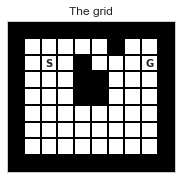

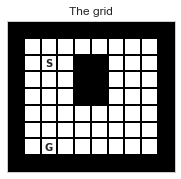

In [8]:
# Visualise the two environments

# Instantiate the two tabular environments
grid = Grid()
alt_grid = AltGrid()

# Plot tabular environments
grid.plot_grid()
alt_grid.plot_grid()

In [9]:
#@title Policies (Uniformly random and e-greedy) 
#Expected syntax: `policy(q_values)` 

# uniformly random policy
def random_policy(q):
  return np.random.randint(4)


## Helper functions (for visualization and running experiments)

In [10]:
#@title Helper functions for visualisation

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
      
  
def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)
  

def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

In [11]:
#@title [IMPORTANT] Running the experiments

# Simple interaction loop with the MDP:
# 1) Interact with the environment
# 2) Agent gets observation, rewards, and discount from env. 
# and is expected to produce the next action
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
      
    # Interaction wih the MDP
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

In [12]:
#@title Helper functions for visualizing policies
def plot_policy(grid, policy):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  grid.plot_grid()
  plt.hold('on')
  plt.title('Policy Visualization')
  for i in range(9):
    for j in range(10):
      action_name = action_names[policy[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  plt.title('Greedy Policy')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

# RL Lab 1: Tabular Agents

Each agent, should implement a step function:

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

Note: All agents should be in pure Python, not TensorFlow needed for this part.

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `q_values()`:

Tabular agents implement a function `q_values()` returning a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  As in the previous assignment you can use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Q-learning and it's variants needs to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._action = 0
  (...)
```



## 1.0: Overview

We are going to implement:
- Prediction problem: Policy Evaluation
- Towards control: Greedy Improvement 
- Online Tabular SARSA Agent
- Online Tabular Q-learning Agent
- Tabular Experience Replay Q-learning Agent








## 1.1: Policy evaluation and Greedy Improvement

The purpose here is to evaluate a given policy $\pi$ -- compute the value function assoicated with following/employing this policy in a given MDP.

$$ Q^{\pi}(S,A) = \mathbb{E}_{\tau \sim P^{\pi}} [\sum_t \gamma^t R_t| s_0=s,a=a_0]$$

where $\tau = \{s_0, a_0, r_0, s_1, a_1, r_1, \cdots \}$


Algorithm:

**Initialize** $Q(s, a)$ for all s ∈ $\mathcal{S}$ and a ∈ $\mathcal{A}(s)$

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{behaviour_policy}(S)$
 
3. Take action $A$; observe resulting reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma Q(S', \pi(S')) − Q(S, A))$

In [13]:
# uniformly random policy
def random_policy(q):
  return np.random.randint(4)

### Task 1.1.1 [Coding, 10 points]

Complete the code for Policy Evaluation Agent




In [14]:
#@title [Coding Task] Policy Evaluation AGENT
class PolicyEval_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, evaluated_policy, 
      behaviour_policy=random_policy, step_size=0.1):
    self._action = 0
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    
    # ============ YOUR CODE HERE =============
    # initialize your q-values (this is a table of state and action pairs
    # Note: this can be random, but the code was tested w/ zero-initialization 
    # self._q =
    self._q = np.zeros((number_of_states, number_of_actions))
    
  @property
  def q_values(self):    
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    # ============ YOUR CODE HERE =============
    # Q-value table update
    self._q[s, a] += self._step_size*(r + g*self._q[next_s, self._behaviour_policy(self._q[next_s])] - self._q[s, a])
    self._state = next_state
    # Get the action to send to execute in the environment and return it
    self._action = self._behaviour_policy(self._q[next_s])
    #print(f'STATE: {s} ACTION: {a} REWARD: {r} POS: {self._q[s]}  NEXT_ACTION:{self._action}')
    
    return self._action
    

**Try it!** Run the policy evaluation agent, evaluating the uniformly randon policy  on the AltGrid() environment for $\texttt{num_steps} = 1e3, 1e5$. 

Visualise the resulting value functions $Q(s,a)$. Plotting function is provided for you and it takes in a table of q-values

AFTER 100000 STEPS ...


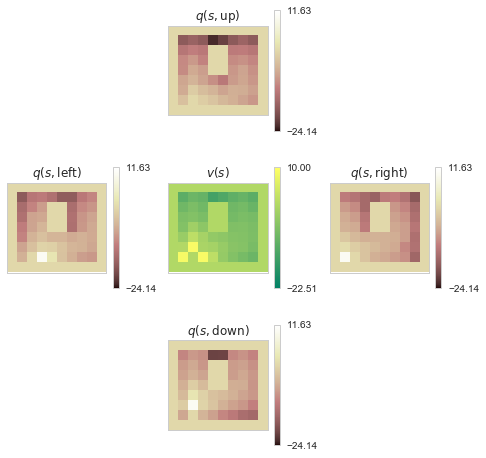

In [18]:
num_steps = int(1e5) # @param

# environment
grid = AltGrid()

# agent 
agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

AFTER 1000 STEPS ...


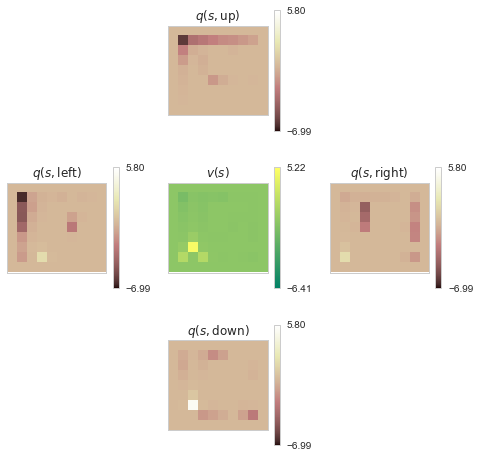

In [12]:
num_steps = int(1e3) # @param

# environment
grid = AltGrid()

# agent 
agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

### Task 1.1.2 [Coding, 4 points]

Compute and Visualise the greedy policy based on the above evaluation, at the end of the training process for $\texttt{num_steps} = 1e5$.


$$ \pi_{greedy} (a|s) = \arg\max_a q^{\mu}(s,a)$$

To do this, complete the code for epsilon_greedy policy below. Remember to break ties randomly.


In [19]:
# @title [Coding Task] epilson-greedy policy
# Input(s): Q(s,:), epsilon
# Output:   Sampled action based on epsilon-Greedy(Q(s,:))
def epsilon_greedy(q_values, epsilon=0.1):
    if np.random.uniform(0,1) < epsilon:
        action = random_policy(q)
    else:
        action = np.argmax(q_values)
    return action
  # return the epsilon greedy action  

c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


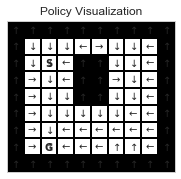

In [20]:
# visualize the greedy policy (whatever works for you, 
# but you should be able to see what the agent would do
# at each step/state)  

pi = np.zeros(grid._layout_dims, dtype=np.int32)
for i in range(grid._layout_dims[0]):
  for j in range(grid._layout_dims[1]):
    pi[i, j] = epsilon_greedy(q[i, j], epsilon=0.)
    
plot_policy(grid, pi)

###  Task 1.1.3 [Question, 4 points]

**Q:** What do you observe? (Remember that we are evaluating the uniformly random policy)

*It seems that in most cases it tries to get away from the walls and in spite of not being perfect (because it's random policy with a low number of iterations) it tends to take the direction that leads to the goal*

### Task 1.1.4 [Question, 4 points]

Re-run the same experiment: policy evaluation agent on the Grid() environment for $\texttt{num_steps} = 1e5$
and visualise the resulting value functions and the greedy policy on top of these values at the end of training.

**Q:** What do you observe? 
- a) How does this policy compare with the optimal one?
- b) Try running the training process longer -- what do you observe?

*a) 1e5 steps in Grid enviroment find a way in almost all scenarios and also tends to penalize hitting the walls*

*b) Running the process longer: no longer gets stuck and always reaches the goal*

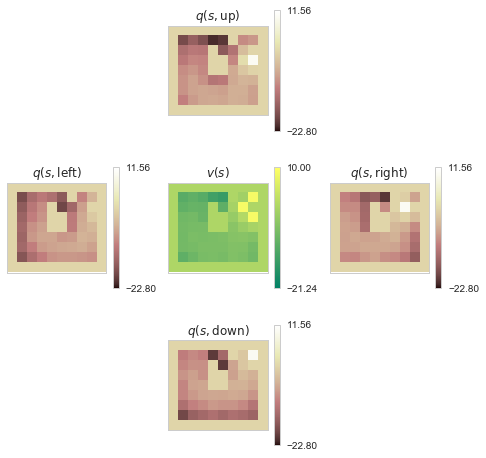

In [25]:
num_steps = int(1e5) # @param

grid = Grid()

agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
plot_action_values(q)

c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


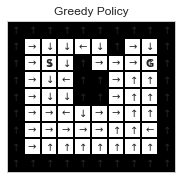

In [26]:
# visualise the greedy policy
plot_greedy_policy(grid, q)

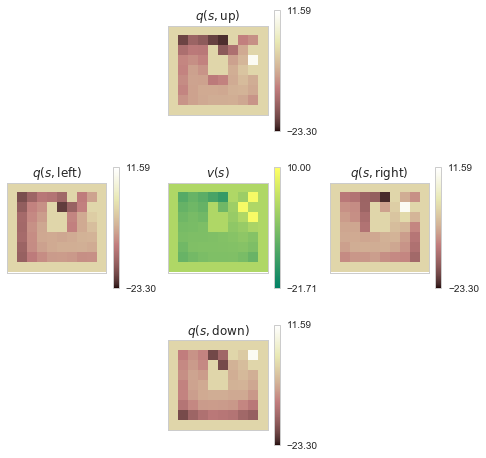

In [27]:
num_steps = int(1e6) # @param

grid = Grid()

agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
plot_action_values(q)

c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


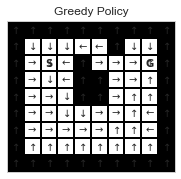

In [28]:
# visualise the greedy policy
plot_greedy_policy(grid, q)

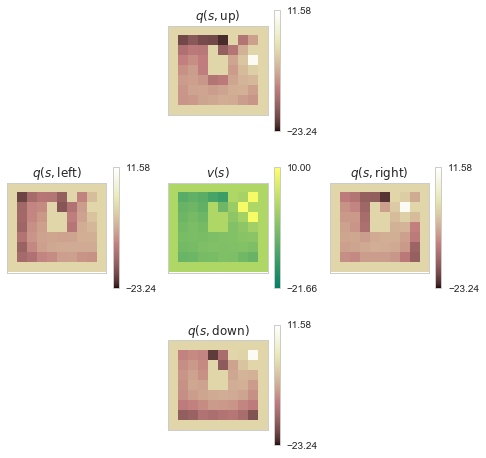

In [29]:
num_steps = int(3e6) # @param

grid = Grid()

agent = PolicyEval_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
plot_action_values(q)

c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


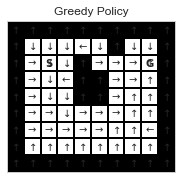

In [30]:
# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.2 On-policy control: SARSA Agent
In the following we are going to be concerned with the control problem -- inferring the optimal value/policy that will 'solve' the MDP. The first algorithm we are going to be looking at is SARSA. 

Note: This is an **on-policy algoritm** -- i.e: the data collection is done on-policy.


**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{current_policy}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma Q(S', A') − Q(S, A))$

### Task 1.2.1 [Coding, 14 points]

Complete the code for the SARSA Agent




In [32]:
#@title [Coding Task] SARSA Agent
class SARSA_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._action = 0
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # ============ YOUR CODE HERE =============
    # Q-value table update
    # td_error =
    # self._q[s, a] =
    #print(next_s, s, a)
    a = int(a)
    td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
    self._q[s, a] += self._step_size * td_error
    
    # Get the action to send to execute in the environment and return it
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

### Task 1.2.2 [Question, 6 points]

**Consider** the SARSA agent with different levels of exploration. 

- Moderate exploration: $\texttt{epsilon} = 0.1$. 

- Very exploratory strategy: $\texttt{epsilon} = 0.5, 1.0$.

**Q**: Which do you expect, without running the experiment, to do better?  

*In SARSA, the agent starts in a first state, performs a first action, and gets a reward for that first action. Then, it’s in a second state and performs another action and gets the reward from this second state then gones back to update the value of first action performed in first state. With this in mind, the lower the exploration for this agent, the better results will be obtained because decisions that will harm in long term won´t be taken*

### Task 1.2.3 [Question, 4 points]

**Q** Run multiple times. What do you observe? ($\texttt{epsilon} = 0.1$)
 
 *Running it several times with epsilon 0.1 there are not many changes, as you would expect for such a small epsilon. With this small epsilon SARSA is doing little exploration, its fiding only one path and then keeps following and reinforcing it*

AFTER 100000 STEPS ...


c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


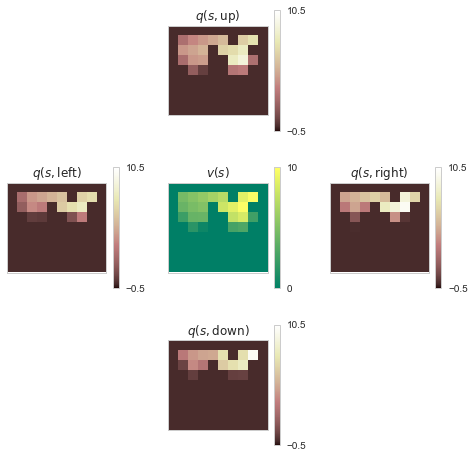

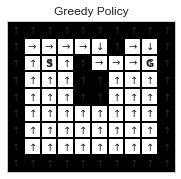

In [41]:
epsilon = 0.1 #@param
num_steps = int(1e5) #@param

grid = Grid(discount=0.9, penalty_for_walls=-1.)

behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)
agent = SARSA_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)




# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

AFTER 100000 STEPS ...


c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


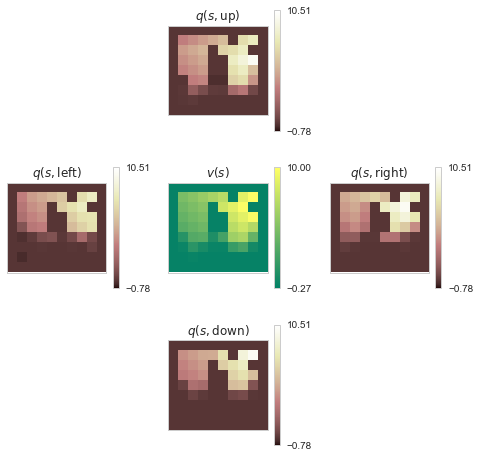

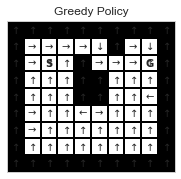

In [42]:
epsilon = 0.5 #@param
num_steps = int(1e5) #@param

grid = Grid(discount=0.9, penalty_for_walls=-1.)

behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)
agent = SARSA_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)




# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

AFTER 100000 STEPS ...


c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


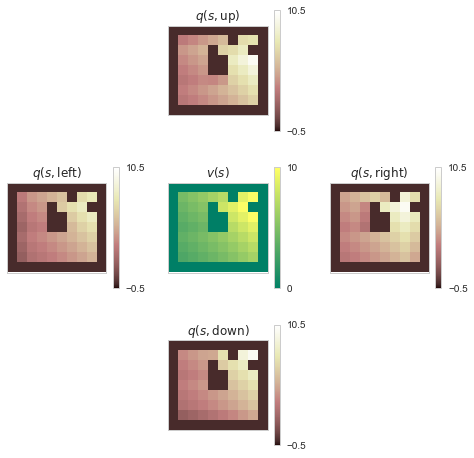

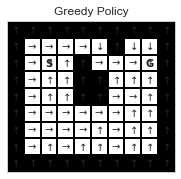

In [35]:
epsilon = 1. #@param
num_steps = int(1e5) #@param

grid = Grid(discount=0.9, penalty_for_walls=-1.)

behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)
agent = SARSA_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)




# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.3 Off-policy control: Q-learning Agent

Reminder: Q-learning is a very powerful and general algorithm, that enable control (figuring out the optimal policy/value function) both on and off-policy.

**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{behaviour_policy}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$



### Task 1.3.1 [Coding, 14 points]

Complete the code for the Q-learning Agent

In [44]:
#@title [Coding Task] Q-learning AGENT
class QLearning_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    pass
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # ============ YOUR CODE HERE =============
    # Q-value table update
    self._q[s, a] += self._step_size*(r + g*self._behaviour_policy(self._q[next_s]) - self._q[s, a])
    #print(self._q[next_state])
    # Get the action to send to execute in the environment and return it
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

**Try it!** **Run** your Q-learning agent on the below environment for 1e5 number of steps
Keep the rest, to the default values, for this first step. We'll get to experiment with this later.

In [45]:
# enviroment
grid = Grid(discount=0.9, penalty_for_walls=-1.)

AFTER 100000 STEPS ...


c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


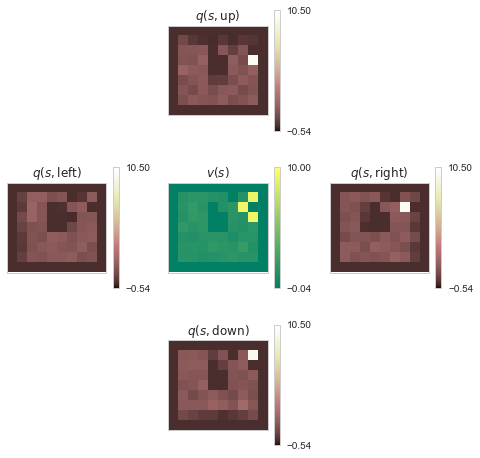

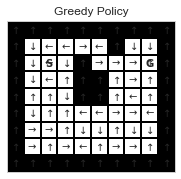

In [46]:
epsilon = 1.0 #@param
num_steps = int(1e5) #@param

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearning_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

AFTER 100000 STEPS ...


c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


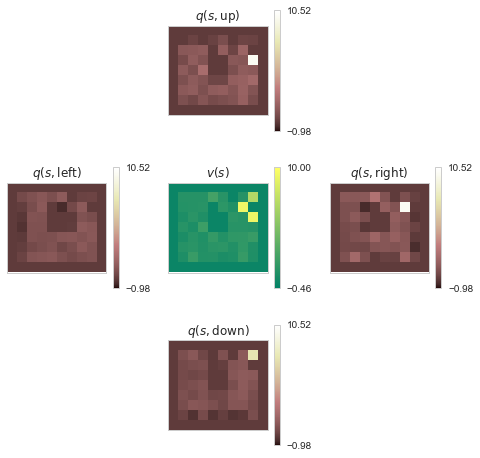

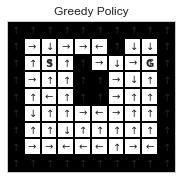

In [47]:
epsilon = .5 #@param
num_steps = int(1e5) #@param

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearning_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

AFTER 100000 STEPS ...


c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


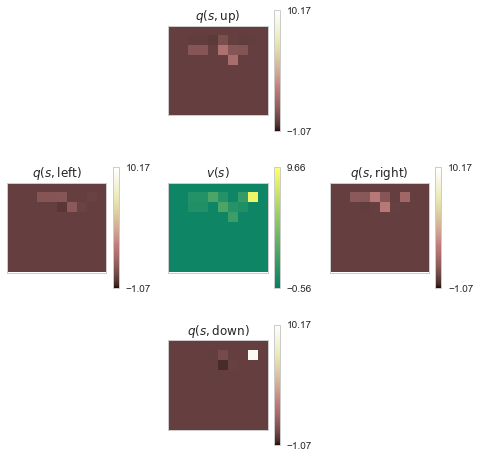

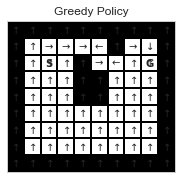

In [49]:
epsilon = .1 #@param
num_steps = int(1e5) #@param

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearning_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    behaviour_policy=behavior_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualise value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

### Task 1.3.2 [Question, 4 points]

Experiment with different levels of 'greediness'

**Q:** The default was $\epsilon=1$, what does this correspond to?

$\epsilon=1$ *is the same as a random policy because is choosing a random action with probability 1* 

###Task 1.3.3 [Question, 6 points]

**Q:** Try also $\epsilon =0.1, 0.5$. What do you observe? Does the behaviour policy affect the training in any way?

*Yes, with a lower epsion we can see less exploration/none in the lower side*

## 1.4 Experience Replay

 Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning 
* apply multiple Q-learning updates based on transitions sampled from the *replay buffer* (in addition to the online updates).

**Initialize** $Q(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S, a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

###Task 1.4.1 [Coding, 14 points]

Complete the code for the Q-learning Agent with replay buffer

In [58]:
#@title [Coding Task] Q-learning AGENT with a simple replay buffer
class ReplayQ_AGENT(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._num_offline_updates = num_offline_updates
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    
    # initialise replay buffer
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    # Online Q-value update
    td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
    self._q[s, a] += self._step_size * td_error
    
    # ============ YOUR CODE HERE =============
    if self._num_offline_updates > 0:

      # Store sample into replay buffer memory
      
    
      # ============ YOUR CODE HERE =============
      # Q-value table update based on online sample and offline samples
      # This update is the same as the above (Q-learning Agent) but 
      # now we are going to be using samples from the replay buffer.
      # Note: You can COPY this from the above Q_learning Agent
      self._q[s, a] += self._step_size*(r + g*self._behaviour_policy(self._q[next_s]) - self._q[s, a])
    
      self._state = next_state
      self._action = self._behaviour_policy(self._q[next_state])

    # Get the action to send to execute in the environment and return it
    self._state = next_state
    self._action = self._behaviour_policy(self._q[next_state])
    
    return self._action

**Try it!**

AFTER 10000 STEPS ...


c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
c:\users\nicol\appdata\local\programs\python\python37\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


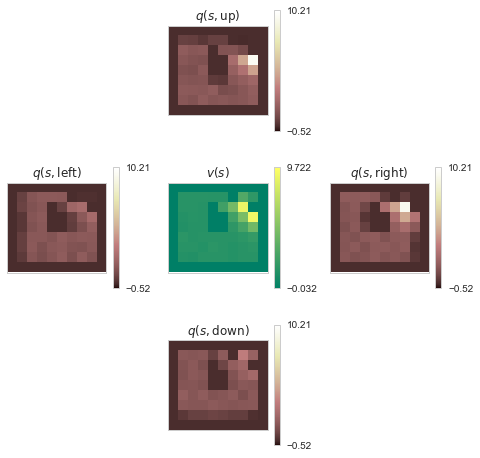

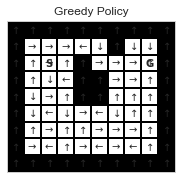

In [64]:
num_offline_updates=30 #@param
num_steps = int(1e4) #@param

grid = Grid(discount=0.9, penalty_for_walls=-1.)

behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)
agent = ReplayQ_AGENT(
    number_of_states=grid._layout.size, 
    number_of_actions=4, 
    initial_state=grid.get_obs(),
    num_offline_updates=num_offline_updates, 
    step_size=0.1,
    behaviour_policy=behavior_policy)

# run experiment and get the value functions from agent
run_experiment(grid, agent, num_steps)
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q)

# visualise the greedy policy
plot_greedy_policy(grid, q)

## 1.5 Further Analysis:  Data Efficiency

**Online Q-learning**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

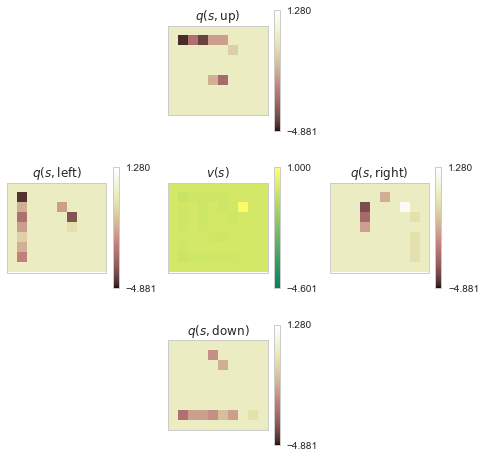

In [65]:
grid = Grid()
agent = ReplayQ_AGENT(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

**Experience Replay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

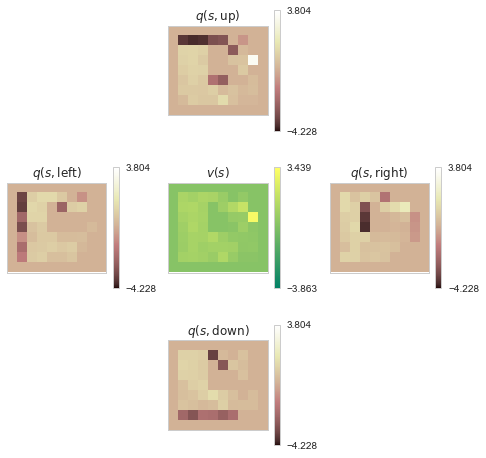

In [66]:
grid = Grid()
agent = ReplayQ_AGENT(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Task 1.5.1 [Question, 8 points] 

**Q** Why does ExperienceReplay obtain a better solution, considering it has the same amount of actual interactions with the environment as online Q-learning?

*ExperienceReplay uses previous experience by learning with it multiple time while Q-learning updates are incremental and do not converge quickly, so multiple passes with the same data is beneficial*


# RL Lab 2: REINFORCE Agent with Function Approximation 

## REINFORCE Agent

We are still trying to solve the control problem: estimate the policy that gives us a better long term (discounted) return:

$$G_t = \sum_{k=t+1} \gamma^{k-t-1}R_k $$

Objective:
$$J(\theta) = \mathbb{E}_{\pi_{\theta}} [G_t]$$


Using the log-derivative trick, we can obtain the gradient of $J(\theta)$ with respect to the policy parameters $\theta$ as:

$$\nabla_{\theta} J = \mathbb{E}_{{\pi_{\theta}}}[\sum_{t}\nabla_{\theta}\log \pi_{\theta}(s_t,a_t) G_t]$$

We estimate this gradient via sampling episodes in the enviroment.



## Functional Approximation involved
**Approximate** $ \pi(s,a)$ for all s ∈ S and a ∈ A(s) via a functional approximator (in our case a sonnet/tensorflow model) and learn this function directly. In the second part we will introduce a baseline in the form a value function $V(s)$ that will be represented by an additional functional approximator.


### Reference and Further Reading
For futher information and refresher on this algorithm and general policy-gradient approached, please check out Chapter 13: Policy Gradient Methods in Sutton & Barto's  book.Models covered in this tutorial: 

13.3 REINFORCE: Monte Carlo Policy Gradient (2.1)

13.4 REINFORCE with Baseline (2.2)

## 2.1 (Vanilla) REINFORCE


### 2.1.1 Build agent
This is slipt into two part:
* Build the Policy functional approximator
* Build the REINFORCE Agent

Note: In the code below we will be using (by default) very simple transformations (linear layers) as this colab is design to focus on the RL algorithm. Please check out previous colab from the summer school for more reference on specifying more interesting functional approximation instances (convolutional nets, LSTM-s, etc) and feel free to experiment with other, more intricated networks. Whenever designing these, always try to keep in mind what are the properties and requirements for the functions you are trying to approximated -- e.g. whether or not you need longer term dependencies, or whether the current observation is sufficient to estimate the target values/intended transformations.

In [15]:
#@title Helper code: Episode Logging
# Book keeping of some useful (episode) statistics
Logging_EpStats = namedtuple("Logging_EpStats", 
                             ["episode_lengths", "episode_rewards"])   

# We are going to be storing transitions encountered in the episode to use 
# later in the update (at the end of the episode, for REINFORCE)
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "discount"])

### Task 2.1.1 [Coding, 14 points]

Complete the code for the Policy function approximation

In [21]:
#@title [Coding Task] Policy Approximator
#Define a class that build our policy approximation
class PolicyApproximator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, num_actions=4, learning_rate=0.01, scope="policy_approximation"):
        with tf.variable_scope(scope):
            # This is a function of the state V(state)
            self.state = tf.placeholder(tf.int32, [], "state")
            
            # Embbed the state into a one-hot coding
            state_one_hot = tf.one_hot(self.state, int(grid._layout.size))
            
            # We are be evaluating the policy of a (previously) selected action
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(tf.float32, [None])
            # Very simple (linear) transformation of the state to 
            # \pi_{\theta}(a|s) -- this is can be anything you think
            # your solution class needs to span the intermediate sol.
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=num_actions,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            

            # ============ YOUR CODE HERE =============
            # Compute pi(a=self.action|s) for a selected action
            # self.action_probs =
            self.action_probs = tf.nn.softmax(self.output_layer)
            
            # Define the loss
            # self.loss = 
            self.loss = -tf.log(self.action_probs[0, self.action]) * self.target
            # Define an optimizer
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            # Define the training operation
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
      # ============ YOUR CODE HERE =============
      sess = sess or tf.get_default_session()
      # compute the probabilities of all actions given 
      # this state \pi(a|s) for all a.
      #pi_a_s = 
      #pi_a_s = self.sess.run(self.action_probs, feed_dict = state)
      pi_a_s = sess.run(self.action_prob, feed_dict={self.state_input: [state]})

      return pi_a_s

    def update(self, state, target, action, sess=None):
      # ============ YOUR CODE HERE =============
      sess = sess or tf.get_default_session()
      # perform training/operation operation
      # compute and return the loss
      return loss

### Task 2.1.2 [Coding, 12 points]

Complete the code for the REINFORCE Agent

In [22]:
#@title [Coding Task] REINFORCE AGENT
class REINFORCE_AGENT(object):
  
  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      policy_learning_rate=0.01, const_discount=1.0):
    
    self._policy_approximator = PolicyApproximator(num_actions=number_of_actions,
                                                   learning_rate=policy_learning_rate)
    self._constant_discount = const_discount 
    
    # initial state/action
    self._state = initial_state
    self._action = 0
    
  def step(self, state):
    # ============ YOUR CODE HERE =============
    # Get the action probabilities 
    # action_probs = 
    
    # Select you action
    # action = 
    
    # Update the internal variables
    self._action = action
    self._state = state
    return self._action
    
  def update(self, episode):
    # go over the all experience collected in this episode
    for t, transition in enumerate(episode):
      
      # ============ YOUR CODE HERE =============
      # Compute the (discounted) return
      # discounted_return = 
      
      # Update our policy estimator based on return
      # self._policy_approximator.update(...)
      
      pass

In [23]:
#@title [IMPORTANT] Run REINFORCE agent with an environment 'env'
# Description:
# Simple experiment run loop (similar to the one above for tabular experiments)
# -----------------------------------------------------------------------------
# Expected behaviour 
# 1) For each episode repeat:
#  - Interact with the environment (get observation and discount)
#  - Store transition
# 2) At the end of the episode, use the stored transition to update agent
# Repeat for num_episode
# -----------------------------------------------------------------------------
# Additional: Log and return episode stastics for plotting later on
# -----------------------------------------------------------------------------
def run_reinforce(env, agent, num_episodes, 
                  MAXSTEPS_PER_EPISODE=100, 
                  REPORT_EVERY_N_STEPS=20):
    """
    Run REINFORCE agent in a MDP especified by 'env'. 
    (Any agent that follows the same logic and can be plugged in though.)
    
    Agent requirements:
      agent.step(state)
      agent.update(episode)
    
    Enviroment requirements:
      env.step(action)
    
    -----------------------------------------------------------------------
    Inputs:
        env: gridworld
        agent: REINFORCE agent (or alternative)
        num_episodes: Number of episodes to run for
    
    Returns:
        Logging_EpStats: episode statistics (episode_length & episode_reward)
    """

    # Book-keeping of some useful (episode) statistics
    stats = Logging_EpStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
      
        # Reset the environment and pick the first action
        action = 0 #agent.initial_action()
        reward, discount, next_state = env.step(action)
        
        episode = []
        
        # One step in the environment
        state = next_state
        for t in range(MAXSTEPS_PER_EPISODE): 
            
            # Take a step
            action = agent.step(state)
            reward, discount, next_state = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, discount=discount))
            
            # Optional: Logging and reporting (live) statistics for this epsiode
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # (Live) reporting
            if ((discount == 0) | (t==MAXSTEPS_PER_EPISODE-1)) & (i_episode%REPORT_EVERY_N_STEPS==0):
                # Print out which step we're on, useful for debugging
                print("Episode {}/{}: Length {} ({})".format(
                i_episode + 1, num_episodes, t, stats.episode_rewards[i_episode - 1]))

            if discount == 0: # this signals end of the episode          
                break
                
            state = next_state
    
        # Go through the episode and make policy updates
        agent.update(episode)
      
    return stats

### 2.1.2. Run experiment
 Ready go! Let's test our agent!

In [24]:
# initialise an instance of the environment
grid = Grid(discount=1.0)

In [25]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

agent = REINFORCE_AGENT(number_of_states=grid._layout.size,
                        number_of_actions=4, 
                        initial_state=grid.get_obs(), 
                        policy_learning_rate=0.01, 
                        const_discount=1.0)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~500-1000 should be okay
    stats = run_reinforce(grid, agent, 500)

NameError: name 'action' is not defined

In [0]:
plot_stats(stats, window=10)

## 2.2 **Adding** a baseline (via $V(s)$) 

### 2.2.1. Build the Agent
This is similar to the above agent, but now we have an additional problem of estimating/computing the value function $v(s)$.

Your tasks will be:
* Implement the value function approximator: prediction/update
* Adjust the above agent to include this baseline 
(Note: make sure you remember to update both your value and policy approx.)

### Task 2.2.1 [Coding, 12 points]

Complete the code for the value function approximator


In [0]:
#@title [Coding Task] Value function approximator 
class ValueApproximator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_approximation"):
        with tf.variable_scope(scope):
          
            # This is a function of the state V(state)
            self.state = tf.placeholder(tf.int32, [], "state")
            # Embbed the state into a one-hot coding
            state_one_hot = tf.one_hot(self.state, int(grid._layout.size))
            
            # ============ YOUR CODE HERE =============
            # Target Q-value function
            # self.target = ...
            
            # Very simple (linear) transformation of the state to 
            # the value function V_{\theta}(s) 
            
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.value_estimate = tf.squeeze(self.output_layer)
            
            # ============ YOUR CODE HERE =============
            # Define the loss
            # self.loss = 
            
            # Define an optimizer
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            # Define the training operation
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
      sess = sess or tf.get_default_session()
      # ============ YOUR CODE HERE =============
      # v_s = 
      return v_s

    def update(self, state, target, sess=None):
      sess = sess or tf.get_default_session()
      # ============ YOUR CODE HERE =============
      # loss =
      return loss

### Task 2.2.2 [Coding, 12 points]

Complete the code for the REINFORCE agent with baseline

In [0]:
#@title [Coding Task] REINFORCE with baseline via estimating V(s)
class REINFORCE_AGENT(object):
  
  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      policy_learning_rate=0.01, value_learning_rate=0.1, const_discount=1.0,
      use_baseline=True):
    
    self._value_approximator  = ValueApproximator(learning_rate=value_learning_rate)
    self._policy_approximator = PolicyApproximator(learning_rate=policy_learning_rate)
    self._constant_discount = const_discount 
    
    # initial state/action
    self._state = initial_state
    self._action = 0
    self._use_baseline = use_baseline
    
  def step(self, state):
    # ============ YOUR CODE HERE =============
    # Note: you an COPY this from above
    # Select the action to send to the environment
    self._action = action
    self._state = state
    return self._action
    
  def update(self, episode):
    
    # go over the all experience collected in this episode
    for t, transition in enumerate(episode):
      # ============ YOUR CODE HERE =============
      # Compute the discounted return
      # discounted_return = 
      
      if self._use_baseline:
        # ============ YOUR CODE HERE =============
        # Compute baseline/advantage
        # baseline = 
        
        # Compute advantage
        # advantage = 
        
        # Update our value estimator
        # self._value_approximator.update(...)
        
        # Update our policy estimator
        # self._policy_approximator.update(...)
        pass
      else:
        # Update our policy estimator based on return
        # self._policy_approximator.update(...)
        pass
    

### 2.2.2. Run experiment

In [0]:
grid = Grid(discount=1.0)

In [0]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)

agent = REINFORCE_AGENT(number_of_states=grid._layout.size,
                        number_of_actions=4, 
                        initial_state=grid.get_obs(), 
                        policy_learning_rate=0.01, 
                        value_learning_rate=0.1, 
                        const_discount=1.0,
                        use_baseline=True)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well.
    stats = run_reinforce(grid, agent, 500)

In [0]:
plot_stats(stats, window=10)

### Task 2.2.3 [Question, 8 points]

Consider the way in which function approximation was implemented for this agent. How would you say its performance would compare to that of a Tabular agent (after both have converged)? Why?

*Answer here.*